# Load Data

In [1]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from loguru import logger

In [2]:
plt.style.use("ggplot")

In [36]:
file_path = "./data/lotr.txt"
# file_path = "/data/text8"

In [37]:
with open(file_path) as f:
    text = f.read()
print(text[:200])

Three Rings for the Elven-kings under the sky,
               Seven for the Dwarf-lords in their halls of stone,
            Nine for Mortal Men doomed to die,
              One for the Dark Lord on h


# Pre-process

In [38]:
def preprocess(text, remove_frequency):
    import nltk
    from nltk.corpus import stopwords
    nltk.download('stopwords')

    punctuations = {
        '.': ' <PERIOD> ',
        ',': ' <COMMA> ',
        '"': ' <QUOTATION_MARK> ',
        '\'': ' <QUOTATION_MARK> ',
        ';': ' <SEMICOLON> ',
        '!': ' <EXCLAMATION_MARK> ',
        '?': ' <QUESTION_MARK> ',
        '(': ' <LEFT_PAREN> ',
        ')': ' <RIGHT_PAREN> ',
        '--': ' <HYPHENS> ',
        '?': ' <QUESTION_MARK> ',
        ':': ' <COLON> '
    }

    # Replace punctuation markers
    text = text.lower()
    for key, value in punctuations.items():
        text = text.replace(key, value)
    words = text.split()

    stop_words_set = set(stopwords.words())
    for punctuation_token in punctuations.values():
        stop_words_set.add(punctuation_token.strip())

    # filter out in-frequent and stop words
    word_counts = Counter(words)
    filtered = [word for word in words if (word_counts[word] > remove_frequency and word not in stop_words_set)]
    return filtered

In [39]:
filter_frequency = 10
words = preprocess(text, filter_frequency)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ksharma/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [40]:
word_counts = Counter(words)

# Top Words

In [41]:
unique_words = list(word_counts.keys())
unique_words.sort(key=lambda x: -word_counts[x]) # descending order
word_tokens = {word: idx for idx, word in enumerate(unique_words)}
total_counts = sum(word_counts.values())
word_frequencies = {x: y / total_counts for x, y in word_counts.items()}
top_20 = unique_words[:20]
top_20_frequency = [word_frequencies[x] for x in top_20]

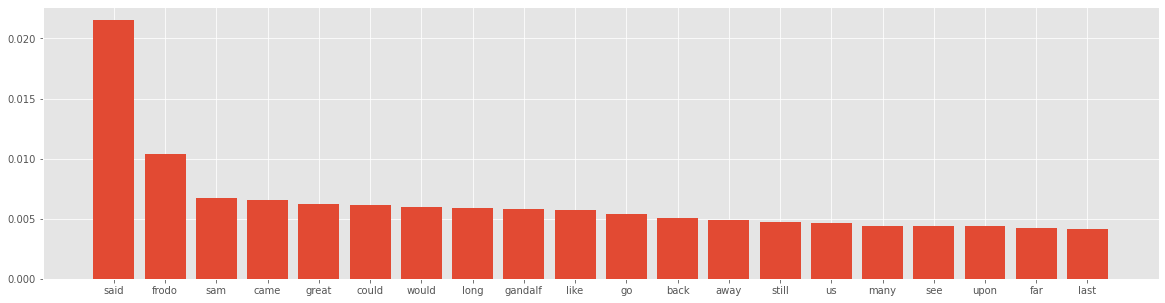

In [42]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.bar(x=top_20, height=top_20_frequency)
plt.show()

# Mini-batching

In [43]:
def generate_word_context(idx, words, window):
    half = window // 2
    left = max(0, idx - half)
    right = min(left + window, len(words))
    if right == len(words):
        left = right - window
    surrounding_words = words[left:right]
    context_tokens = [word_tokens[x] for x in surrounding_words if x != words[idx]]
    return context_tokens

In [44]:
def generate_batches(words, batch_size, window):
    batch_count = len(words) // batch_size
    words = words[:(batch_size * batch_count)]
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx + batch_size]
        for i, word in enumerate(batch):
            word_token = word_tokens[word]
            context_tokens = generate_word_context(i, words, window)
            x.extend([word_token] * len(context_tokens))
            y.extend(context_tokens)
        yield x, y

In [45]:
batches = generate_batches(words, 5, 4)
x, y = next(batches)
x, y

([160,
  160,
  160,
  700,
  700,
  700,
  200,
  200,
  200,
  625,
  625,
  625,
  1149,
  1149,
  1149],
 [700, 200, 625, 160, 200, 625, 160, 700, 625, 700, 200, 1149, 200, 625, 108])

In [46]:
import torch
from torch import nn
import torch.optim as optim



class SkipGram(nn.Module):
    def __init__(self, n_vocab, n_embed):
        super().__init__()
        
        self.embed = nn.Embedding(n_vocab, n_embed)
        self.output = nn.Linear(n_embed, n_vocab)
        self.log_softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = self.embed(x)
        scores = self.output(x)
        log_likelihood = self.log_softmax(scores)
        # Alternatively, we can use the scores directly and apply Cross-entropy loss
        return log_likelihood

In [47]:
inputs, targets = torch.LongTensor(x), torch.LongTensor(y)

In [48]:
skip_gram_model = SkipGram(len(word_tokens), 20)
outputs = skip_gram_model(inputs)
print(outputs.shape)

torch.Size([15, 2735])


In [49]:
loss_function = nn.NLLLoss()

In [50]:
loss_function(outputs, targets)

tensor(7.9918, grad_fn=<NllLossBackward>)

In [54]:
embedding_dim = 200
model = SkipGram(len(word_tokens), embedding_dim)
optimizer = optim.Adam(model.parameters(), lr=0.005)

print_frequency = 100
steps = 0
epochs = 2

batch_size = 32
window = 5

for epoch in range(1, epochs + 1):
    logger.info(f"Started epoch {epoch}")
    for x, y in generate_batches(words, batch_size, window):
        steps += 1
        inputs, targets = torch.LongTensor(x), torch.LongTensor(y)
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if steps % print_frequency == 0:
            logger.info(f"[Epoch {epoch}] [Step {steps}]: Loss Value: {loss.item()}")

2021-04-27 22:12:35.996 | INFO     | __main__:<module>:13 - Started epoch 1
2021-04-27 22:12:36.499 | INFO     | __main__:<module>:23 - [Epoch 1] [Step 100]: Loss Value: 4.845653533935547
2021-04-27 22:12:36.970 | INFO     | __main__:<module>:23 - [Epoch 1] [Step 200]: Loss Value: 4.126715183258057
2021-04-27 22:12:37.435 | INFO     | __main__:<module>:23 - [Epoch 1] [Step 300]: Loss Value: 4.03758430480957
2021-04-27 22:12:37.942 | INFO     | __main__:<module>:23 - [Epoch 1] [Step 400]: Loss Value: 4.009410381317139
2021-04-27 22:12:38.415 | INFO     | __main__:<module>:23 - [Epoch 1] [Step 500]: Loss Value: 3.491919994354248
2021-04-27 22:12:38.868 | INFO     | __main__:<module>:23 - [Epoch 1] [Step 600]: Loss Value: 3.4958407878875732
2021-04-27 22:12:39.318 | INFO     | __main__:<module>:23 - [Epoch 1] [Step 700]: Loss Value: 3.3863954544067383
2021-04-27 22:12:39.774 | INFO     | __main__:<module>:23 - [Epoch 1] [Step 800]: Loss Value: 3.7186851501464844
2021-04-27 22:12:40.228 | 

# Test word similarity - Cosine Similarity

In [55]:
embedding_weights = model.embed.weight
embedding_norms = embedding_weights.pow(2).sum(dim=1).sqrt()
normed_embedding = (embedding_weights.t() / embedding_norms).t()

exmaple_count = 50
random_set = np.arange(50)
examples = torch.LongTensor(random_set)
example_words = [unique_words[token] for token in examples]
example_embeddings = model.embed(examples)
similarities = torch.mm(example_embeddings, normed_embedding.t())

_, top_k_similar = similarities.topk(6)
similar = np.array(unique_words)[top_k_similar.numpy()][:, 1:]

for i, word in enumerate(example_words):
    print(f"{word} : {similar[i]}")

said : ['would' 'go' 'frodo' 'sam' 'came']
frodo : ['said' 'stood' 'danced' 'great' 'would']
sam : ['said' 'drew' 'shadow' 'go' 'marshes']
came : ['said' 'yet' 'look' 'osgiliath' 'without']
great : ['frodo' 'said' 'gave' 'way' 'hobbits']
could : ['arm' 'lost' 'way' 'go' 'greater']
would : ['said' 'frodo' 'indeed' 'fear' 'way']
long : ['seemed' 'corner' 'peril' 'tinúviel' 'meriadoc']
gandalf : ['said' 'go' 'river' 'minas' 'perish']
like : ['city' 'shining' 'north' 'gave' 'servants']
go : ['said' 'reek' 'decided' 'sam' 'gandalf']
back : ['seeing' 'think' 'said' 'lord' 'beside']
away : ['think' 'sam' 'tongue' 'said' 'company']
still : ['see' 'balin' 'said' 'horseman' 'warn']
us : ['wide' 'saw' 'said' 'place' 'loud']
many : ['river' 'master' 'halt' 'slain' 'quite']
see : ['still' 'cry' 'said' 'wish' 'fear']
upon : ['play' 'frodo' 'go' 'leaf' 'course']
far : ['said' 'empty' 'nowhere' 'get' 'seemed']
last : ['éowyn' 'lawn' 'says' 'red' 'saruman']
dark : ['said' 'might' 'sam' 'fly' 'deadly']


In [56]:
frequencies = list(word_frequencies.values())
frequencies.sort(reverse=True)

In [57]:
unigram_factor = .75
smoothed_dist = np.power(frequencies, unigram_factor)


In [58]:
def generate_batches(words, batch_size, noise_count, window):
    batch_count = len(words) // batch_size
    words = words[:(batch_size * batch_count)]
    for idx in range(0, len(words), batch_size):
        target, context = [], []
        batch = words[idx:idx + batch_size]
        for i, word in enumerate(batch):
            word_token = word_tokens[word]
            context_tokens = generate_word_context(i, words, window)
            target.extend([word_token] * len(context_tokens))
            context.extend(context_tokens)
        yield np.array(target), np.array(context), np.random.choice(
            len(noise_dist), size=len(target) * noise_count, replace=True, p=noise_dist).reshape(len(target), noise_count)

In [59]:
batches = generate_batches(words, 10, 5, 40)

In [60]:
class SkipGramNegativeSampling(nn.Module):
    def __init__(self, vocab_size, embed_size):
        super().__init__()
        self.input_embedding = nn.Embedding(vocab_size, embed_size)
        self.output_embedding = nn.Embedding(vocab_size, embed_size)
        self.input_embedding.weight.data.uniform_(-1, 1)
        self.output_embedding.weight.data.uniform_(-1, 1)
    
    def forward(self, target, context, noise):
        target_embed = self.input_embedding(target)
        context_embed = self.output_embedding(context)
        noise_embed = self.output_embedding(noise)
        return target_embed, context_embed, noise_embed

In [66]:
class NegativeSamplingLoss(nn.Module):
    def forward(self, target, context, noise):
        batch_size, embed_size = target.shape
        target = target.view(batch_size, embed_size, 1)
        context = context.view(batch_size, 1, embed_size)
       
        output_loss = torch.bmm(context, target).sigmoid().log().squeeze()
        noise_loss = torch.bmm(noise.neg(), target).sigmoid().log().squeeze().sum(1)
        return -(output_loss + noise_loss).mean()

In [69]:
embedding_dim = 150
model = SkipGramNegativeSampling(len(word_tokens), embedding_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = NegativeSamplingLoss()

print_frequency = 100
steps = 0
epochs = 2

batch_size = 32
window = 5
noise_words = 5

for epoch in range(1, epochs + 1):
    logger.info(f"Started epoch {epoch}")
    for x, y, n in generate_batches(words, batch_size=batch_size, noise_count=noise_words, window=window):
        steps += 1
        target, context, noise = torch.LongTensor(x), torch.LongTensor(y), torch.LongTensor(n)
        target_embed, context_embed, noise_embed = model(target, context, noise)
        loss = loss_function(target_embed, context_embed, noise_embed)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if steps % print_frequency == 0:
            logger.info(f"[Epoch {epoch}] [Step {steps}]: Loss Value: {loss.item()}")

2021-04-27 22:33:56.640 | INFO     | __main__:<module>:15 - Started epoch 1
2021-04-27 22:33:57.013 | INFO     | __main__:<module>:25 - [Epoch 1] [Step 100]: Loss Value: 10.910740852355957
2021-04-27 22:33:57.357 | INFO     | __main__:<module>:25 - [Epoch 1] [Step 200]: Loss Value: 10.109518051147461
2021-04-27 22:33:57.693 | INFO     | __main__:<module>:25 - [Epoch 1] [Step 300]: Loss Value: 9.514039039611816
2021-04-27 22:33:58.048 | INFO     | __main__:<module>:25 - [Epoch 1] [Step 400]: Loss Value: 10.194342613220215
2021-04-27 22:33:58.384 | INFO     | __main__:<module>:25 - [Epoch 1] [Step 500]: Loss Value: 9.873336791992188
2021-04-27 22:33:58.734 | INFO     | __main__:<module>:25 - [Epoch 1] [Step 600]: Loss Value: 9.31712532043457
2021-04-27 22:33:59.080 | INFO     | __main__:<module>:25 - [Epoch 1] [Step 700]: Loss Value: 10.077784538269043
2021-04-27 22:33:59.432 | INFO     | __main__:<module>:25 - [Epoch 1] [Step 800]: Loss Value: 8.74406623840332
2021-04-27 22:33:59.763 | 

In [70]:
embedding_weights = model.input_embedding.weight
embedding_norms = embedding_weights.pow(2).sum(dim=1).sqrt()
normed_embedding = (embedding_weights.t() / embedding_norms).t()

examples = torch.LongTensor(np.arange(100))
example_words = [unique_words[token] for token in examples]
example_embeddings = model.input_embedding(examples)
similarities = torch.mm(example_embeddings, normed_embedding.t())

_, top_k_similar = similarities.topk(6)
similar = np.array(unique_words)[top_k_similar.numpy()][:, 1:]

for i, word in enumerate(example_words):
    print(f"{word} : {similar[i]}")

said : ['like' 'came' 'looked' 'stood' 'back']
frodo : ['came' 'many' 'saruman' 'time' 'though']
sam : ['age' 'lord' 'black' 'us' 'like']
came : ['said' 'frodo' 'stood' 'ring' 'sat']
great : ['black' 'could' 'long' 'said' 'must']
could : ['know' 'great' 'night' 'us' 'behind']
would : ['fear' 'upon' 'entered' 'great' 'long']
long : ['road' '–' 'great' 'hand' 'away']
gandalf : ['yet' 'towards' 'like' 'back' 'upon']
like : ['said' 'well' 'back' 'mist' 'night']
go : ['said' 'aragorn' 'lie' 'frodo' 'flat']
back : ['said' 'like' 'gandalf' 'looked' 'journey']
away : ['yet' 'long' 'much' 'chief' 'go']
still : ['shire' 'night' 'must' 'windows' 'world']
us : ['hand' 'sam' 'wood' 'could' 'set']
many : ['frodo' 'said' 'sight' 'sky' 'could']
see : ['seemed' 'wind' 'soon' 'always' 'sam']
upon : ['said' 'looking' 'gandalf' 'looked' 'like']
far : ['tall' 'lord' 'set' 'nothing' 'darkness']
last : ['middle-earth' 'way' 'towards' 'speaking' 'shall']
dark : ['light' 'grey' 'upon' 'hills' 'air']
yet : ['ga